In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'

# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
2453,PRV54057,No


In [5]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
3825,BENE24709,CLM79747,2009-12-16,2009-12-21,PRV53244,13000,PHY427085,PHY325044,NaN,2009-12-16,6826,1068.0,2009-12-21,579,6822,4019,3384,51884,42832,25040,94524,2724,2761,NaN,9929.0,NaN,NaN,NaN,NaN,NaN


In [6]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
75083,BENE32413,CLM198308,2009-02-16,2009-02-16,PRV55454,400,PHY374226,NaN,NaN,30393,95901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [7]:
# convert dates to datetime format in outpatient
outpatient['ClaimStartDt'] = pd.to_datetime(outpatient['ClaimStartDt'])
outpatient['ClaimEndDt'] = pd.to_datetime(outpatient['ClaimEndDt'])
outpatient['ClaimDuration'] = (outpatient['ClaimEndDt'] - outpatient['ClaimStartDt']).dt.days.astype(int)
outpatient.sample(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimDuration
32450,BENE20266,CLM408899,2009-06-11,2009-07-01,PRV51707,30,PHY354903,NaN,PHY354903,V5869,V4586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,20
300758,BENE97282,CLM437625,2009-06-26,2009-06-26,PRV53045,2200,PHY421454,NaN,NaN,7238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,72210,0
309233,BENE99737,CLM588432,2009-09-19,2009-09-19,PRV56556,300,PHY327728,PHY324109,NaN,7039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
459672,BENE142479,CLM656745,2009-10-30,2009-10-30,PRV55167,30,PHY346857,PHY349162,NaN,V5869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [8]:
outpatient['ClaimDuration'].value_counts()

ClaimDuration
0     453348
20     24312
1      11960
2       4366
14      2735
3       2597
7       2564
4       2238
5       1511
9       1378
6       1306
8       1189
16      1136
10       982
15       975
11       953
13       947
12       903
17       808
18       800
19       727
23         1
21         1
Name: count, dtype: int64

In [9]:
inpatient['Provider'].nunique()

2092

In [10]:
# convert dates to datetime format in Inpatient
inpatient['ClaimStartDt'] = pd.to_datetime(inpatient['ClaimStartDt'])
inpatient['ClaimEndDt'] = pd.to_datetime(inpatient['ClaimEndDt'])
inpatient['ClaimDuration'] = (inpatient['ClaimEndDt'] - inpatient['ClaimStartDt']).dt.days.astype(int)
inpatient.sample(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
33989,BENE135636,CLM65004,2009-08-22,2009-08-23,PRV54824,5000,PHY334097,PHY334097,NaN,2009-08-22,57420,1068.0,2009-08-23,432,57511,41401,V5331,4019,30001,5758,78062,41400,NaN,NaN,5123.0,NaN,NaN,NaN,NaN,NaN,1
25434,BENE104318,CLM75539,2009-11-11,2009-11-14,PRV52123,4000,PHY417954,NaN,NaN,2009-11-11,7845,1068.0,2009-11-14,038,43491,V1254,87200,2724,7845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
8833,BENE43667,CLM57470,2009-06-28,2009-06-30,PRV52347,4000,PHY383212,NaN,NaN,2009-06-28,42731,1068.0,2009-06-30,247,42789,1977,4280,4263,42732,V153,V1011,71536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
28393,BENE115173,CLM59381,2009-07-12,2009-07-18,PRV56481,11000,PHY320466,NaN,NaN,2009-07-12,3310,1068.0,2009-07-18,033,33183,78079,29411,4168,V4501,41401,25000,71590,29410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


In [11]:
# aggregate inpatient data by provider and create the dataframe
df = inpatient.groupby('Provider').agg(
    IPClaimDurationSum = ('ClaimDuration', 'sum'),
    # IPClaimDurationCount = ('ClaimDuration', 'count')
).reset_index()
df

,Provider,IPClaimDurationSum
0,PRV51001,25
1,PRV51003,320
2,PRV51007,16
3,PRV51008,8
4,PRV51011,5
...,...,...
2087,PRV57719,55
2088,PRV57728,4
2089,PRV57729,61
2090,PRV57732,58


In [12]:
# Check a specefic provider to make sure the number looks good
inpatient.loc[inpatient['Provider'] == 'PRV51001']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
6904,BENE36012,CLM58316,2009-07-04,2009-07-08,PRV51001,36000,PHY340163,NaN,NaN,2009-07-04,29623,1068.0,2009-07-08,882,29650,2971,3051,V1254,07070,28260,7823,49300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
7611,BENE38773,CLM52334,2009-05-23,2009-05-25,PRV51001,12000,PHY346762,NaN,NaN,2009-05-23,0389,1068.0,2009-05-25,864,0388,5849,2841,2762,7140,E9444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
23936,BENE98831,CLM36844,2009-02-03,2009-02-08,PRV51001,3000,PHY383193,NaN,NaN,2009-02-03,5362,1068.0,2009-02-08,353,56211,5533,0088,5789,53081,27651,7840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
25014,BENE102690,CLM49733,2009-05-04,2009-05-18,PRV51001,42000,PHY383193,PHY378091,PHY389113,2009-05-04,41401,1068.0,2009-05-18,245,4241,42731,4168,2724,4019,42822,2720,45829,53081,NaN,3521.0,2724.0,NaN,NaN,NaN,NaN,14
38474,BENE152088,CLM37205,2009-02-06,2009-02-06,PRV51001,4000,PHY402229,PHY329739,NaN,2009-02-06,80121,1068.0,2009-02-06,062,85222,2724,3310,40390,V4501,V5866,NaN,NaN,NaN,NaN,8659.0,NaN,NaN,NaN,NaN,NaN,0


In [13]:
# Display the datafrom inpatient
df.describe()

,IPClaimDurationSum
count,2092.000000
mean,109.509082
std,201.445013
min,0.000000
25%,17.000000
50%,44.000000
75%,107.000000
max,3044.000000


In [14]:
# Make sure I have the correct number of unique providers from outpatient
outpatient['Provider'].nunique()

5012

In [15]:
# aggregate outpatient data by provider and create the dataframe
out_df = outpatient.groupby('Provider').agg(
    OPClaimDurationSum = ('ClaimDuration', 'sum'),
    # OPClaimDurationCount = ('ClaimDuration', 'count')
).reset_index()
out_df

,Provider,OPClaimDurationSum
0,PRV51001,11
1,PRV51003,165
2,PRV51004,213
3,PRV51005,1268
4,PRV51007,53
...,...,...
5007,PRV57759,60
5008,PRV57760,7
5009,PRV57761,114
5010,PRV57762,0


In [16]:
out_df.describe()

,OPClaimDurationSum
count,5012.000000
mean,146.740223
std,393.160705
min,0.000000
25%,8.000000
50%,41.000000
75%,126.000000
max,11542.000000


In [17]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    df,  # Left
    out_df,  # Right
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [18]:
# The full data before modeling
provider_claims

,Provider,IPClaimDurationSum,OPClaimDurationSum
0,PRV51001,25.0,11.0
1,PRV51003,320.0,165.0
2,PRV51004,0.0,213.0
3,PRV51005,0.0,1268.0
4,PRV51007,16.0,53.0
...,...,...,...
5405,PRV57759,0.0,60.0
5406,PRV57760,0.0,7.0
5407,PRV57761,0.0,114.0
5408,PRV57762,0.0,0.0


In [19]:
# # # Save selected columns to CSV
# provider_claims.to_csv('6 draft.csv', index=False)

In [20]:
provider_claims['IPClaimDurationSum'].sum()

229093.0

In [21]:
provider_claims['OPClaimDurationSum'].sum()

735462.0

In [22]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [23]:
final_df

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud
0,PRV51001,25.0,11.0,No
1,PRV51003,320.0,165.0,Yes
2,PRV51004,0.0,213.0,No
3,PRV51005,0.0,1268.0,Yes
4,PRV51007,16.0,53.0,No
...,...,...,...,...
5405,PRV57759,0.0,60.0,No
5406,PRV57760,0.0,7.0,No
5407,PRV57761,0.0,114.0,No
5408,PRV57762,0.0,0.0,No


In [24]:
# make the potential fraud column binary
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud
0,PRV51001,25.0,11.0,0
1,PRV51003,320.0,165.0,1
2,PRV51004,0.0,213.0,0
3,PRV51005,0.0,1268.0,1
4,PRV51007,16.0,53.0,0
...,...,...,...,...
5405,PRV57759,0.0,60.0,0
5406,PRV57760,0.0,7.0,0
5407,PRV57761,0.0,114.0,0
5408,PRV57762,0.0,0.0,0


In [25]:
# Select the features
X = final_df[['IPClaimDurationSum',
              'OPClaimDurationSum']]

In [26]:
# Select the target
y = final_df['PotentialFraud']

In [27]:
# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [28]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [29]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [30]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities between the 0 and 1 (good for the threshold later)


In [31]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix before manipulating by adjusting the threshold\nConfusion Matrix:")
print(cm)

Confusion Matrix before manipulating by adjusting the threshold
Confusion Matrix:
[[964  13]
 [ 67  38]]


In [32]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.36
F1 Score: 0.49


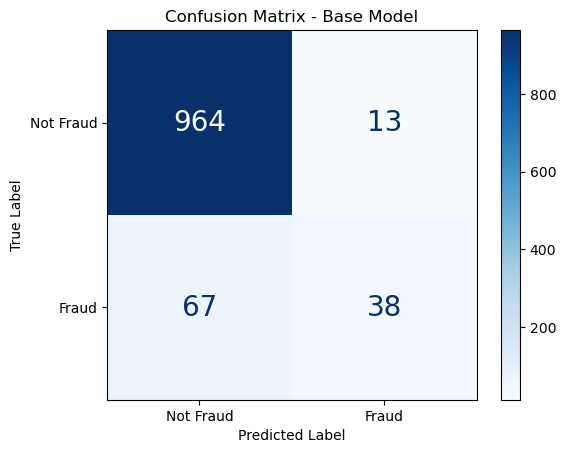

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('Confusion Matrix - Base Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

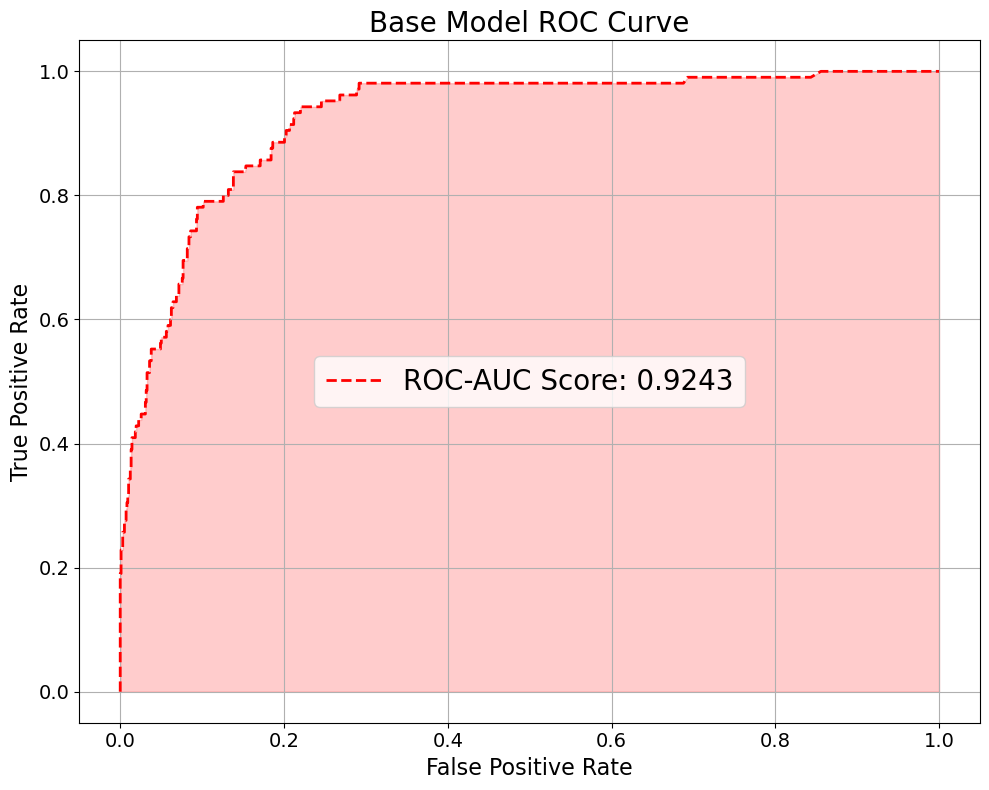

In [34]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC-AUC Score: {roc_auc:.4}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red')
ax.set_title('Base Model ROC Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()

In [35]:
# from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

0.9242676804601062

# Apply cross validation

In [36]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean auc_roc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94358151 0.94657906 0.91701234 0.93756623 0.93335834]
Mean auc_roc: 0.9356


## Hyperparameter Tuning Using `GridSearchCV`

Checking for the best paramters that will gives the best result in the scoring parameter

In [37]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9384


In [38]:
from sklearn.metrics import classification_report, roc_auc_score

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)


y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


Test ROC AUC: 0.9259
              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.81      0.28      0.41       105

    accuracy                           0.92      1082
   macro avg       0.87      0.63      0.69      1082
weighted avg       0.92      0.92      0.91      1082



In [39]:
cm = confusion_matrix(y_test, y_pred)

print("confusion Matrix after GridSearch only:\n",cm)

confusion Matrix after GridSearch only:
 [[970   7]
 [ 76  29]]


In [40]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.92
Precision: 0.81
Recall: 0.28
F1 Score: 0.41


In [41]:
print('Best Logistic Regression Model:\n',best_model)

Best Logistic Regression Model:
 LogisticRegression(C=0.01, max_iter=10000, penalty='l1', solver='liblinear')


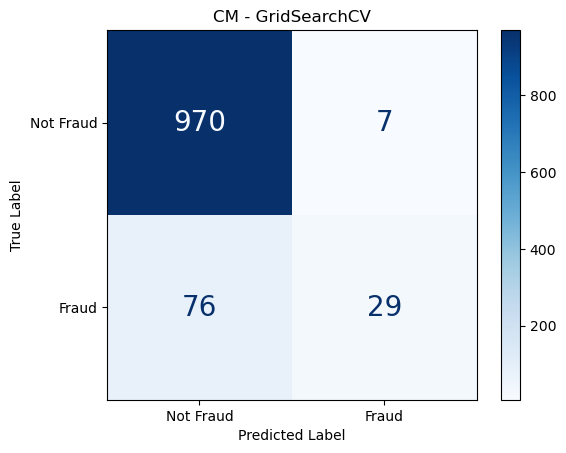

In [42]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('CM - GridSearchCV')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

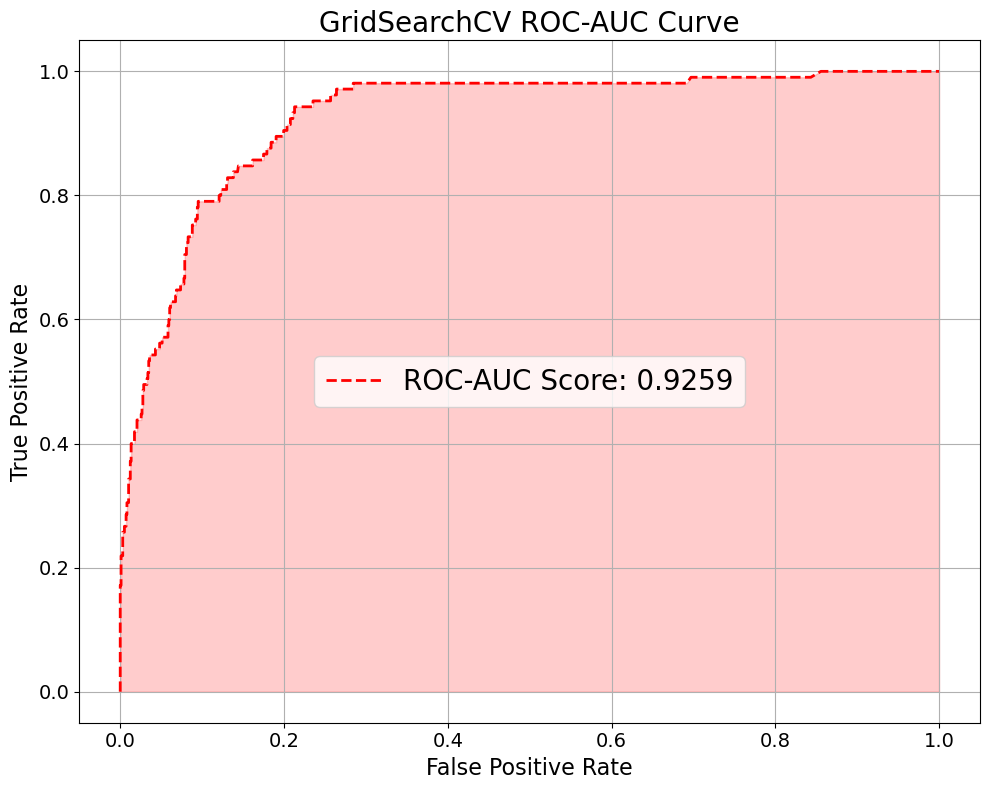

In [43]:
# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=(f'ROC-AUC Score: {roc_auc:.4f}'))
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('GridSearchCV ROC-AUC Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20)
plt.tight_layout()
ax.grid(True)
plt.show()

# <center>SMOTE

In [44]:
# Checks how the data looks like, before applying a new concept (SMOTE)
final_df.head()

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud
0,PRV51001,25.0,11.0,0
1,PRV51003,320.0,165.0,1
2,PRV51004,0.0,213.0,0
3,PRV51005,0.0,1268.0,1
4,PRV51007,16.0,53.0,0


In [45]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [46]:
X

,IPClaimDurationSum,OPClaimDurationSum
0,25.0,11.0
1,320.0,165.0
2,0.0,213.0
3,0.0,1268.0
4,16.0,53.0
...,...,...
5405,0.0,60.0
5406,0.0,7.0
5407,0.0,114.0
5408,0.0,0.0


In [47]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [48]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [49]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[885  96]
 [ 15  86]]


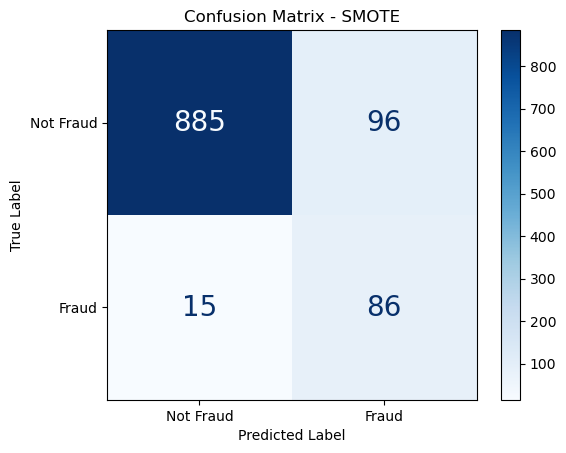

In [50]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('Confusion Matrix - SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [51]:
# cm = confusion_matrix(y_test, y_pred)
# print('Confusion Matrix smote:\n', cm)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.90
Precision: 0.47
Recall: 0.85
F1 Score: 0.61


In [52]:
# print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

### <center>SMOTE AUC_ROC score:

In [53]:
model_after_smote

LogisticRegression(max_iter=10000)

In [54]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9582


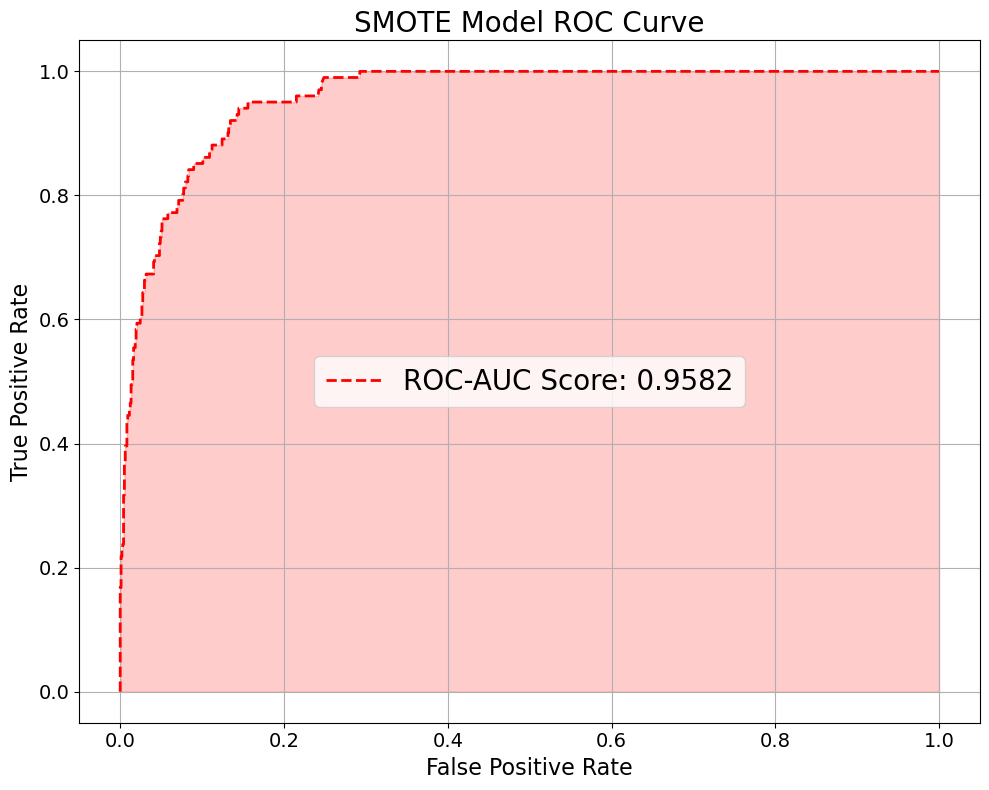

In [55]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC-AUC Score: {roc_auc:.4f}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('SMOTE Model ROC Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20)
plt.tight_layout()
ax.grid(True)
plt.show()

# <center>Grid Search CV
<center>This comes after the smote, so I run the grid search over the smote results

In [56]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


In [57]:
from sklearn.metrics import roc_auc_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)

auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9588


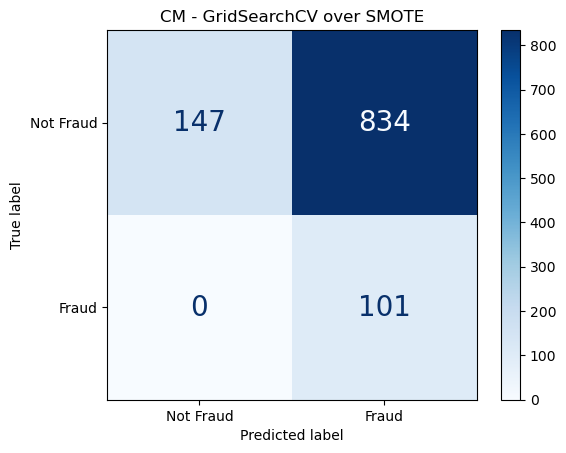

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues', text_kw={'fontsize': 20})
plt.title("CM - GridSearchCV over SMOTE")
plt.show()


In [59]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[147 834]
 [  0 101]]


In [60]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix after all:\n')
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix after all:

Accuracy: 0.23
Precision: 0.11
Recall: 1.00
F1 Score: 0.19


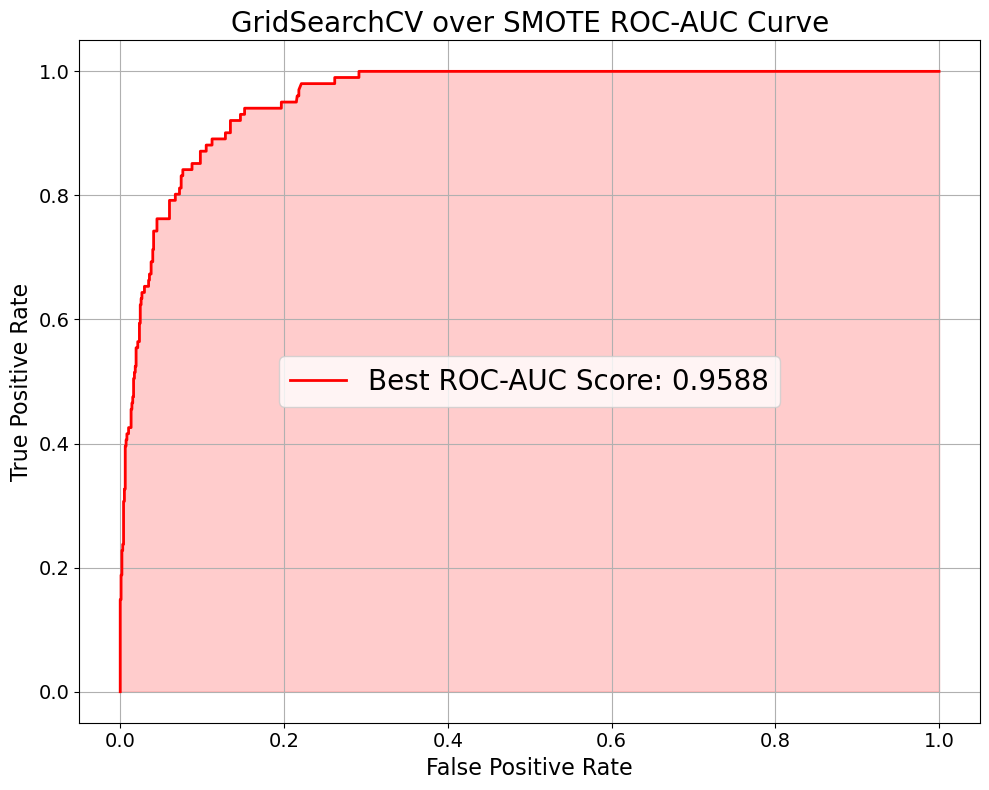

In [61]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r-', lw=2, label=f'Best ROC-AUC Score: {roc_auc:.4f}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('GridSearchCV over SMOTE ROC-AUC Curve', fontsize=20) # tile for the chart
ax.set_xlabel('False Positive Rate', fontsize=16) 
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()


In [62]:
print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9588


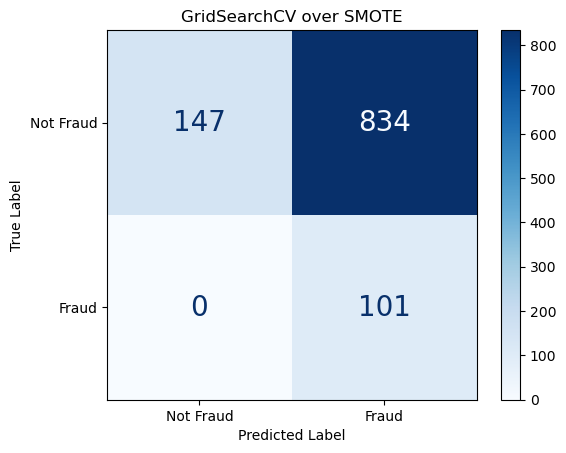

In [63]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('GridSearchCV over SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# *****

In [64]:
final_df

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud
0,PRV51001,25.0,11.0,0
1,PRV51003,320.0,165.0,1
2,PRV51004,0.0,213.0,0
3,PRV51005,0.0,1268.0,1
4,PRV51007,16.0,53.0,0
...,...,...,...,...
5405,PRV57759,0.0,60.0,0
5406,PRV57760,0.0,7.0,0
5407,PRV57761,0.0,114.0,0
5408,PRV57762,0.0,0.0,0


In [65]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'

clm_amnt = pd.read_csv('Data_files/2draft fraud2.csv')
clm_amnt

,Provider,IPReimbursmentTotal,OPReimbursmentTotal
0,PRV51001,97000.0,7640.0
1,PRV51003,573000.0,32670.0
2,PRV51004,0.0,52170.0
3,PRV51005,0.0,280910.0
4,PRV51007,19000.0,14710.0
...,...,...,...
5405,PRV57759,0.0,10640.0
5406,PRV57760,0.0,4770.0
5407,PRV57761,0.0,18470.0
5408,PRV57762,0.0,1900.0


In [66]:
second_model = pd.merge(clm_amnt, final_df, on='Provider', how='outer')
second_model

,Provider,IPReimbursmentTotal,OPReimbursmentTotal,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud
0,PRV51001,97000.0,7640.0,25.0,11.0,0
1,PRV51003,573000.0,32670.0,320.0,165.0,1
2,PRV51004,0.0,52170.0,0.0,213.0,0
3,PRV51005,0.0,280910.0,0.0,1268.0,1
4,PRV51007,19000.0,14710.0,16.0,53.0,0
...,...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,0.0,60.0,0
5406,PRV57760,0.0,4770.0,0.0,7.0,0
5407,PRV57761,0.0,18470.0,0.0,114.0,0
5408,PRV57762,0.0,1900.0,0.0,0.0,0


In [67]:
# Select the features

X = second_model[['IPReimbursmentTotal'	,'OPReimbursmentTotal'	,'IPClaimDurationSum'	,'OPClaimDurationSum']]
y = second_model['PotentialFraud']

In [68]:
# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [69]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities between the 0 and 1 (good for the threshold later)

In [70]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix before manipulating by adjusting the threshold\nConfusion Matrix:")
print(cm)

Confusion Matrix before manipulating by adjusting the threshold
Confusion Matrix:
[[964  13]
 [ 65  40]]


In [71]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.38
F1 Score: 0.51


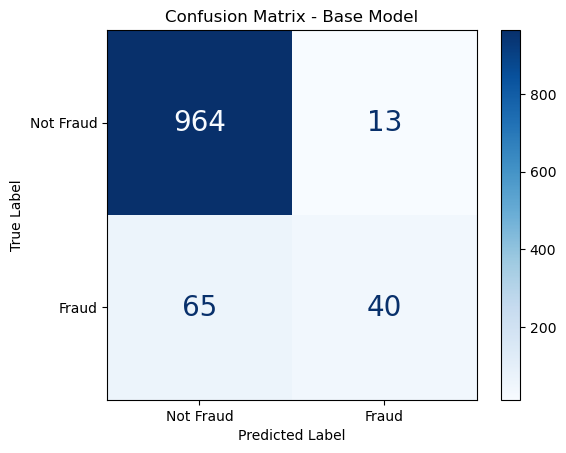

In [72]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('Confusion Matrix - Base Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

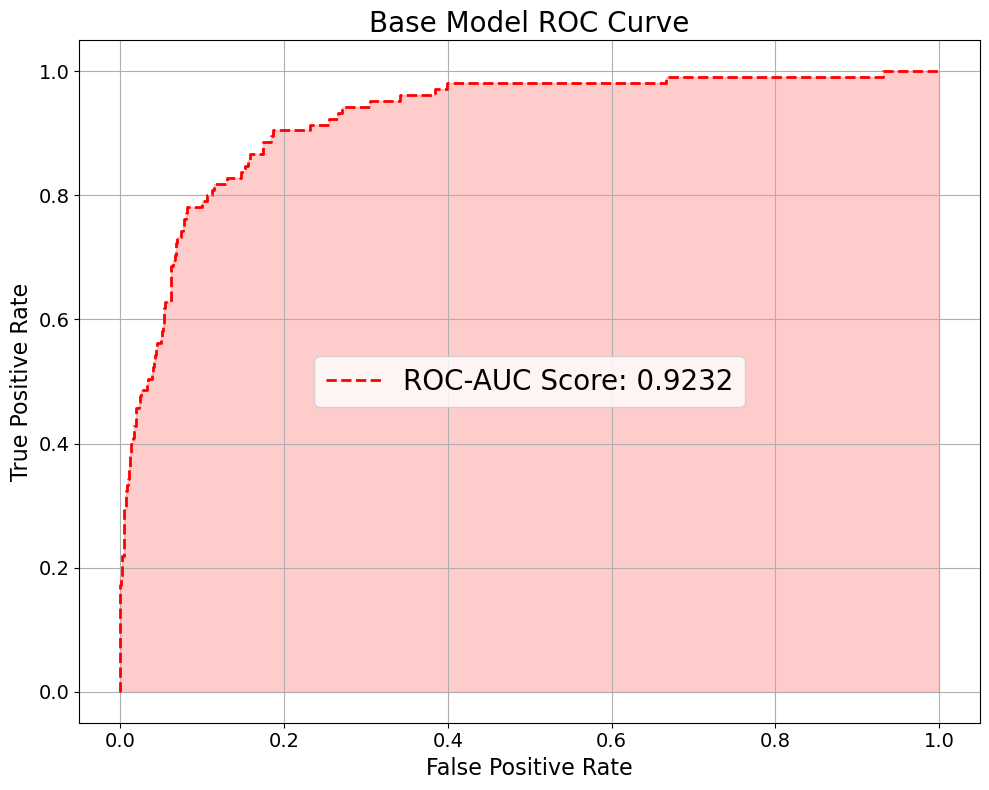

In [73]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC-AUC Score: {roc_auc:.4}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red')
ax.set_title('Base Model ROC Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()

In [74]:
X

,IPReimbursmentTotal,OPReimbursmentTotal,IPClaimDurationSum,OPClaimDurationSum
0,97000.0,7640.0,25.0,11.0
1,573000.0,32670.0,320.0,165.0
2,0.0,52170.0,0.0,213.0
3,0.0,280910.0,0.0,1268.0
4,19000.0,14710.0,16.0,53.0
...,...,...,...,...
5405,0.0,10640.0,0.0,60.0
5406,0.0,4770.0,0.0,7.0
5407,0.0,18470.0,0.0,114.0
5408,0.0,1900.0,0.0,0.0


# Cross Validation (I can ignore)

In [75]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean auc_roc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.9443738  0.9466598  0.91705776 0.92971912 0.93323329]
Mean auc_roc: 0.9342


# 2
## Hyperparameter Tuning Using `GridSearchCV`

Checking for the best paramters that will gives the best result in the scoring parameter

In [76]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9396


In [77]:
from sklearn.metrics import classification_report, roc_auc_score

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)


y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


Test ROC AUC: 0.9258
              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.79      0.31      0.45       105

    accuracy                           0.93      1082
   macro avg       0.86      0.65      0.70      1082
weighted avg       0.92      0.93      0.91      1082



In [78]:
cm = confusion_matrix(y_test, y_pred)

print("confusion Matrix after GridSearch only:\n",cm)

confusion Matrix after GridSearch only:
 [[968   9]
 [ 72  33]]


In [79]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.79
Recall: 0.31
F1 Score: 0.45


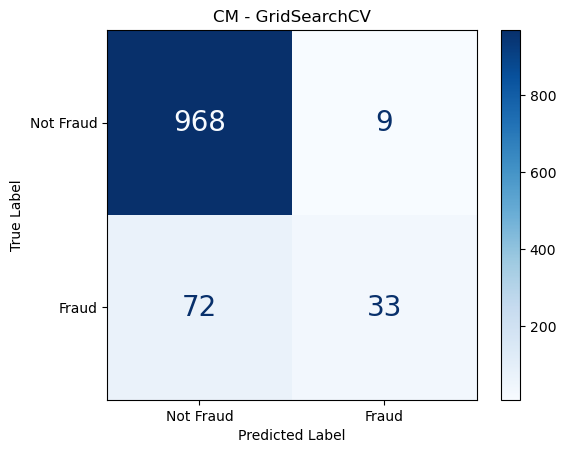

In [80]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('CM - GridSearchCV')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

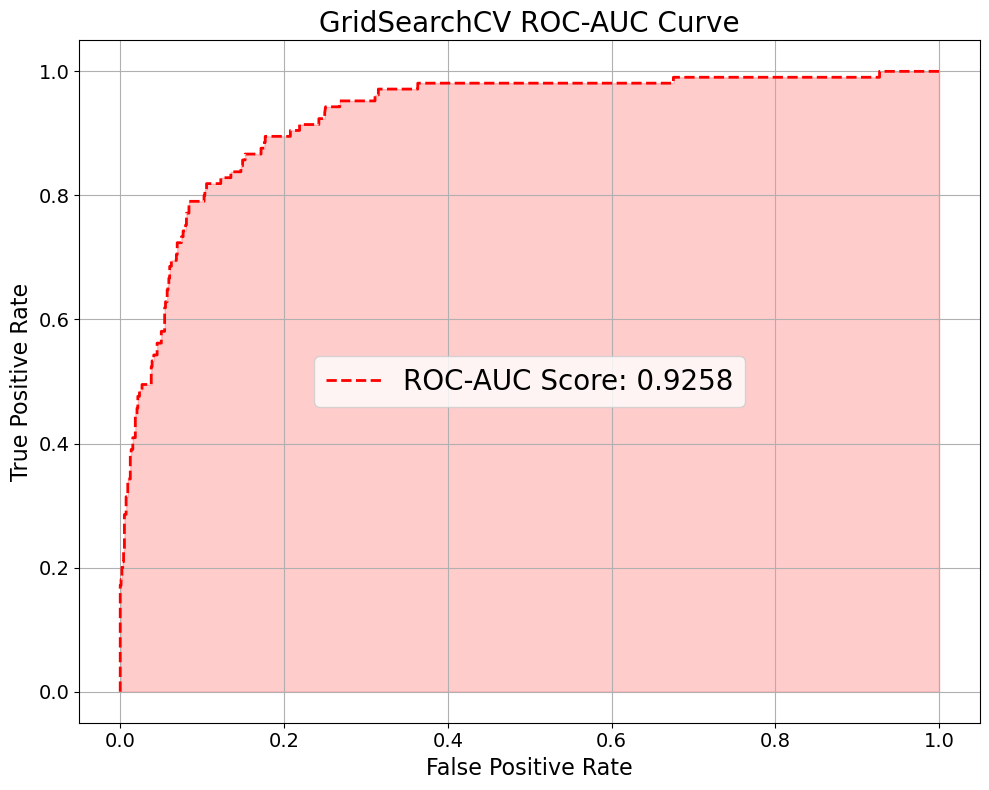

In [81]:
# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=(f'ROC-AUC Score: {roc_auc:.4f}'))
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('GridSearchCV ROC-AUC Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20)
plt.tight_layout()
ax.grid(True)
plt.show()

# SMOTE

In [82]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = second_model.drop(columns=['Provider','PotentialFraud'])
y = second_model['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [83]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [84]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [85]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[886  95]
 [ 18  83]]


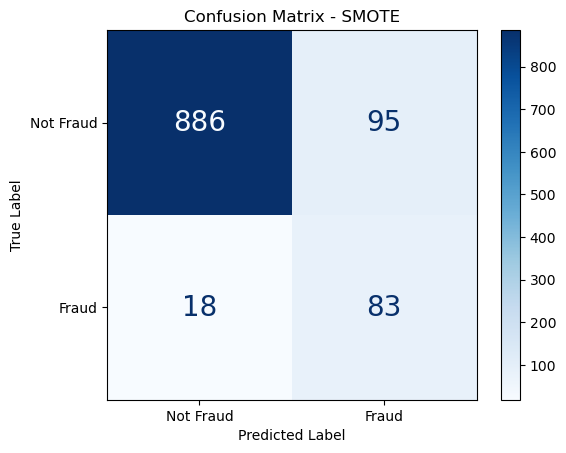

In [86]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('Confusion Matrix - SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [87]:
# cm = confusion_matrix(y_test, y_pred)
# print('Confusion Matrix smote:\n', cm)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.90
Precision: 0.47
Recall: 0.82
F1 Score: 0.59


In [88]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9520


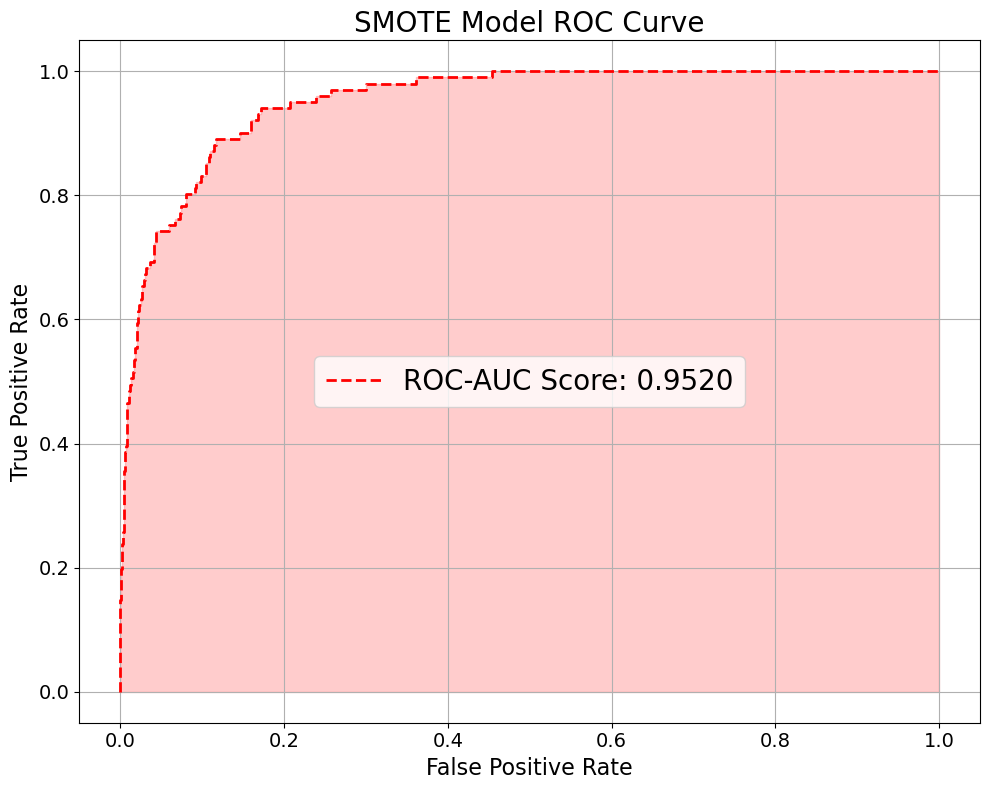

In [89]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC-AUC Score: {roc_auc:.4f}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('SMOTE Model ROC Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20)
plt.tight_layout()
ax.grid(True)
plt.show()

# Not a great improvement
# <center>Grid Search CV
<center>This comes after the smote, so I run the grid search over the smote results

In [90]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}


In [91]:
from sklearn.metrics import roc_auc_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)

auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9536


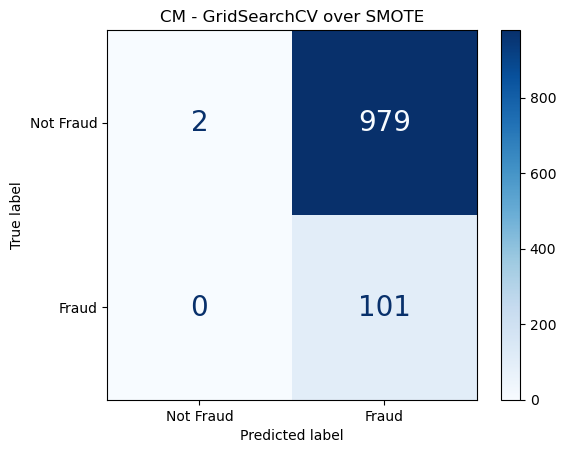

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues', text_kw={'fontsize': 20})
plt.title("CM - GridSearchCV over SMOTE")
plt.show()


In [93]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  2 979]
 [  0 101]]


In [94]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix after all:\n')
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix after all:

Accuracy: 0.10
Precision: 0.09
Recall: 1.00
F1 Score: 0.17


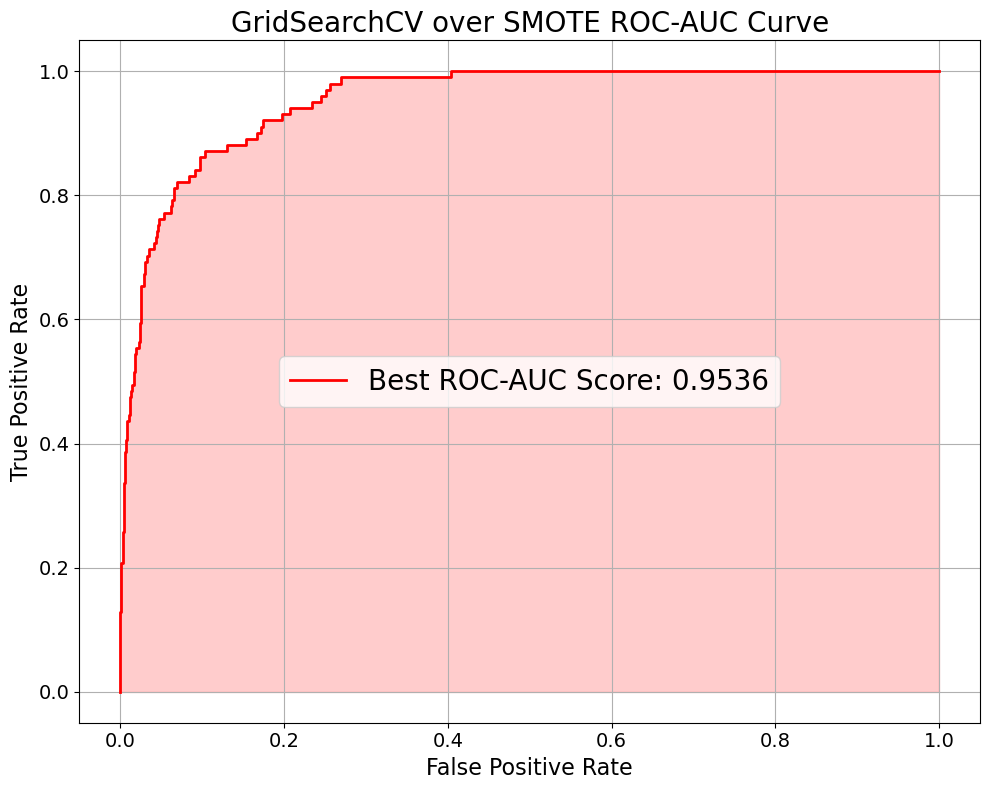

In [95]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r-', lw=2, label=f'Best ROC-AUC Score: {roc_auc:.4f}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('GridSearchCV over SMOTE ROC-AUC Curve', fontsize=20) # tile for the chart
ax.set_xlabel('False Positive Rate', fontsize=16) 
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()


In [96]:
print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9536


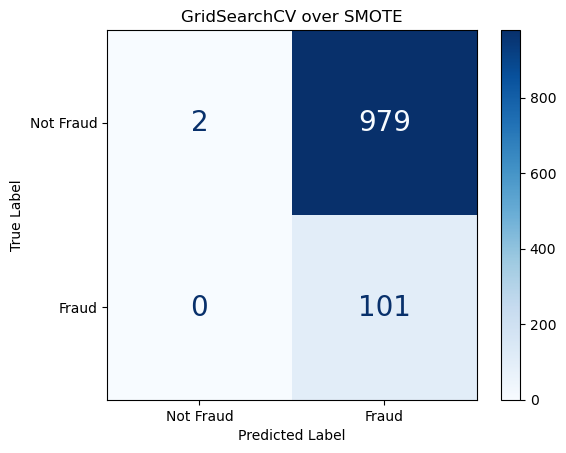

In [97]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('GridSearchCV over SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [98]:
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({1: 'Yes',0: 'No'})

final_df

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud
0,PRV51001,25.0,11.0,No
1,PRV51003,320.0,165.0,Yes
2,PRV51004,0.0,213.0,No
3,PRV51005,0.0,1268.0,Yes
4,PRV51007,16.0,53.0,No
...,...,...,...,...
5405,PRV57759,0.0,60.0,No
5406,PRV57760,0.0,7.0,No
5407,PRV57761,0.0,114.0,No
5408,PRV57762,0.0,0.0,No


<Figure size 1000x500 with 0 Axes>

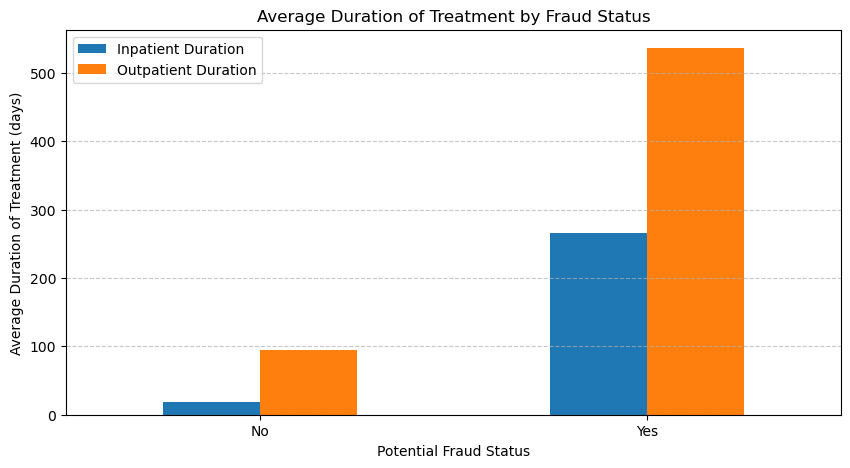

In [99]:
import matplotlib.pyplot as plt

# Grouping by PotentialFraud and calculating mean reimbursement amounts
fraud_summary = final_df.groupby("PotentialFraud")[
    ['IPClaimDurationSum',	'OPClaimDurationSum']
].mean()

# Plotting Inpatient and Outpatient Reimbursement Comparisons
plt.figure(figsize=(10, 5))
fraud_summary.plot(kind="bar", figsize=(10, 5), rot=0)
plt.title("Average Duration of Treatment by Fraud Status")
plt.ylabel("Average Duration of Treatment (days)")
plt.xlabel("Potential Fraud Status")
plt.xticks(rotation=0)
plt.legend(["Inpatient Duration", "Outpatient Duration"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [100]:
fraud_summary

,IPClaimDurationSum,OPClaimDurationSum
PotentialFraud,,
No,19.334217,94.607667
Yes,265.371542,536.573123


In [101]:
final_df

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud
0,PRV51001,25.0,11.0,No
1,PRV51003,320.0,165.0,Yes
2,PRV51004,0.0,213.0,No
3,PRV51005,0.0,1268.0,Yes
4,PRV51007,16.0,53.0,No
...,...,...,...,...
5405,PRV57759,0.0,60.0,No
5406,PRV57760,0.0,7.0,No
5407,PRV57761,0.0,114.0,No
5408,PRV57762,0.0,0.0,No


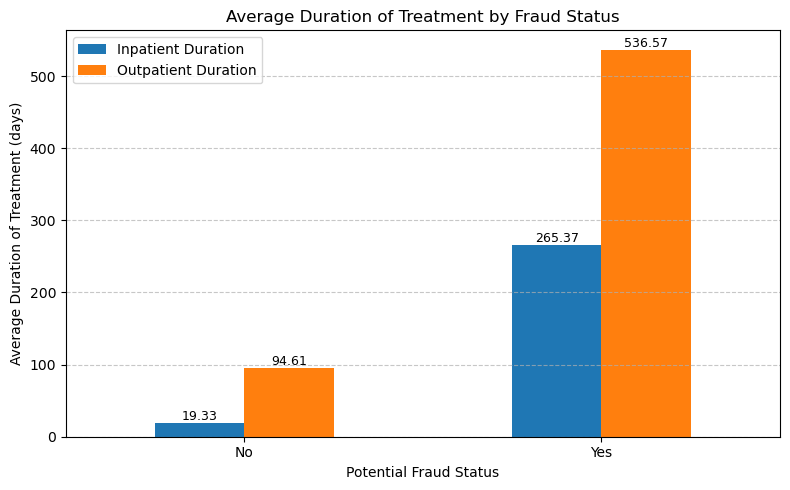

In [147]:
# Grouping by PotentialFraud and calculating mean reimbursement amounts
fraud_summary = final_df.groupby("PotentialFraud")[
    ['IPClaimDurationSum',	'OPClaimDurationSum']
].mean()

# Create a figure and axes first
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data on our axes
fraud_summary.plot(
    kind="bar", 
    ax=ax,     # use the axes we created
    rot=0      # no rotation for x-axis labels
)

ax.set_title("Average Duration of Treatment by Fraud Status")
ax.set_ylabel("Average Duration of Treatment (days)")
ax.set_xlabel("Potential Fraud Status")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(["Inpatient Duration", "Outpatient Duration"])

# Loop through each 'bar container' and label them
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=9)  # or '%.1f', etc.

plt.tight_layout()
plt.show()

In [103]:
final_df.groupby("PotentialFraud")[
    ['IPClaimDurationSum',	'OPClaimDurationSum']
].median()

,IPClaimDurationSum,OPClaimDurationSum
PotentialFraud,,
No,0.0,31.0
Yes,145.5,140.0


In [104]:
final_df.groupby("PotentialFraud")[
    ['IPClaimDurationSum',	'OPClaimDurationSum']
].std()

,IPClaimDurationSum,OPClaimDurationSum
PotentialFraud,,
No,52.834668,187.946439
Yes,341.189736,1014.478714


In [106]:
final_df.groupby("PotentialFraud")[
    ['IPClaimDurationSum',	'OPClaimDurationSum']
].sem()

,IPClaimDurationSum,OPClaimDurationSum
PotentialFraud,,
No,0.754473,2.683854
Yes,15.167734,45.099080


<Axes: xlabel='IPClaimDurationSum', ylabel='Count'>

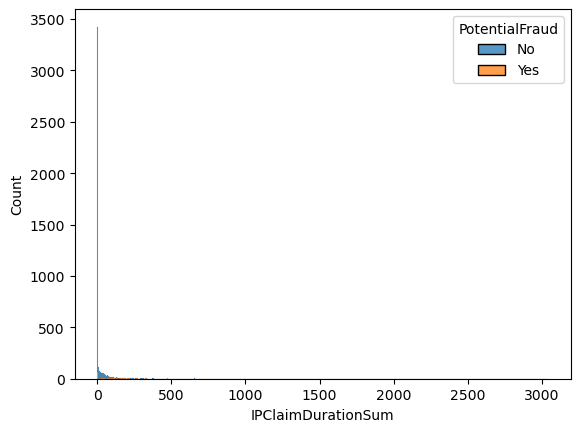

In [ ]:
sns.histplot(data=final_df, x='IPClaimDurationSum',hue='PotentialFraud')

<Axes: xlabel='OPClaimDurationSum', ylabel='Count'>

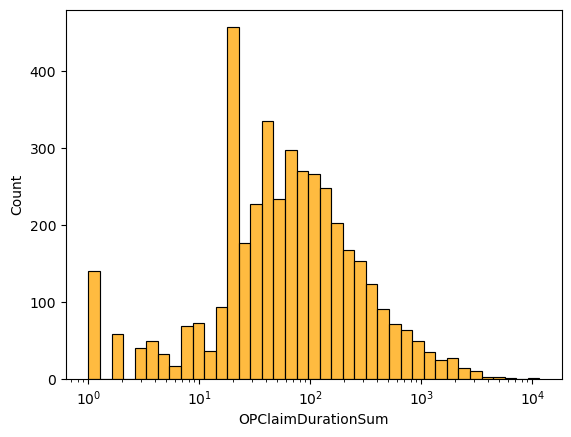

In [143]:
sns.histplot(data=final_df, x='OPClaimDurationSum',log_scale=True, color='orange')


Trying to use log (natural log) for ploting the duration of tritments

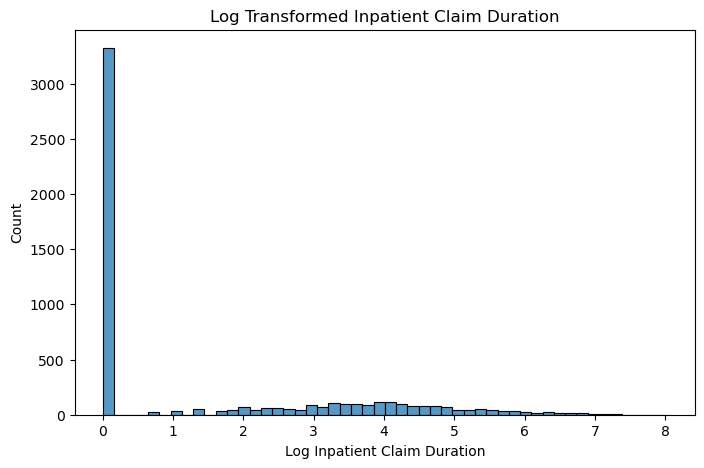

In [140]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(final_df['IPClaimDurationSum']), bins=50)
plt.title('Log Transformed Inpatient Claim Duration')
plt.xlabel('Log Inpatient Claim Duration')
plt.ylabel('Count')
plt.show()

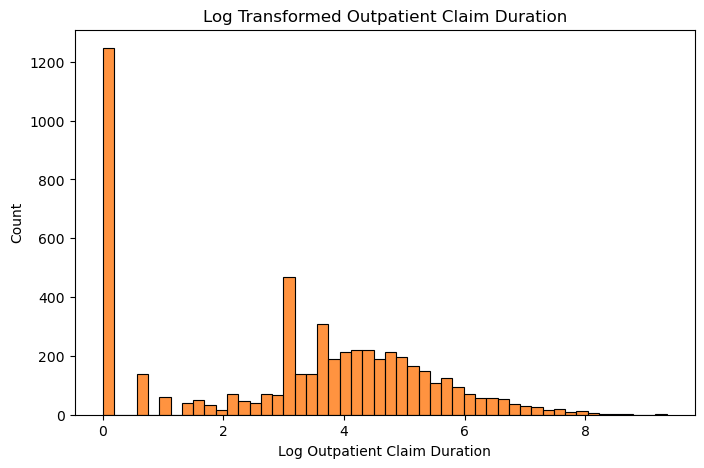

In [146]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(final_df['OPClaimDurationSum']), bins=50, color='#ff6f00')
plt.title('Log Transformed Outpatient Claim Duration')
plt.xlabel('Log Outpatient Claim Duration')
plt.ylabel('Count')
plt.show()

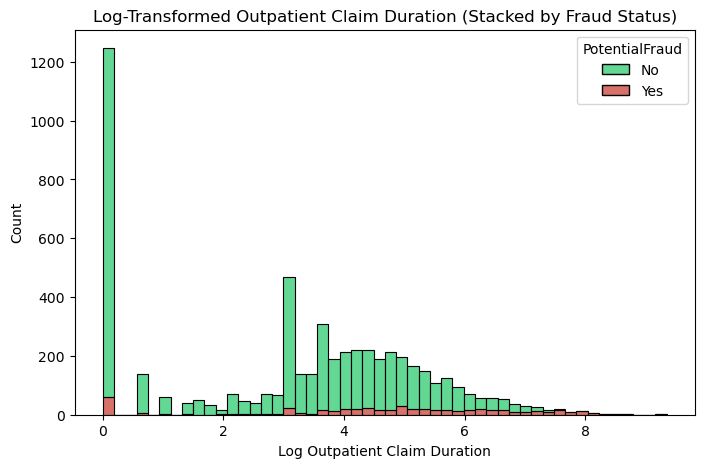

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Create a log-transformed column for clarity
final_df['log_OPClaimDurationSum'] = np.log1p(final_df['OPClaimDurationSum'])

# 2) Plot a stacked histogram, colored by PotentialFraud
plt.figure(figsize=(8,5))
sns.histplot(
    data=final_df,
    x='log_OPClaimDurationSum',
    hue='PotentialFraud',
    multiple='stack',  # ensure stacked bars
    bins=50,
    palette=['#2ecc71','#cb4335'],  # Custom colors for the two categories
)
plt.title('Log-Transformed Outpatient Claim Duration (Stacked by Fraud Status)')
plt.xlabel('Log Outpatient Claim Duration')
plt.ylabel('Count')
plt.show()


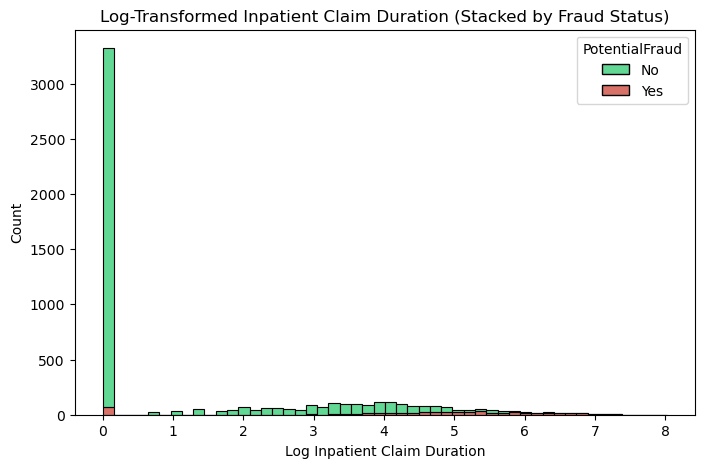

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Create a log-transformed column for clarity
final_df['log_IPClaimDurationSum'] = np.log1p(final_df['IPClaimDurationSum'])

# 2) Plot a stacked histogram, colored by PotentialFraud
plt.figure(figsize=(8,5))
sns.histplot(
    data=final_df,
    x='log_IPClaimDurationSum',
    hue='PotentialFraud',
    multiple='stack',  # ensure stacked bars
    bins=50,
    palette=['#2ecc71','#cb4335'],  # Custom colors for the two categories
)
plt.title('Log-Transformed Inpatient Claim Duration (Stacked by Fraud Status)')
plt.xlabel('Log Inpatient Claim Duration')
plt.ylabel('Count')
plt.show()


In [155]:
final_df

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud,log_OPClaimDurationSum,log_IPClaimDurationSum
0,PRV51001,25.0,11.0,No,2.484907,3.258097
1,PRV51003,320.0,165.0,Yes,5.111988,5.771441
2,PRV51004,0.0,213.0,No,5.365976,0.000000
3,PRV51005,0.0,1268.0,Yes,7.145984,0.000000
4,PRV51007,16.0,53.0,No,3.988984,2.833213
...,...,...,...,...,...,...
5405,PRV57759,0.0,60.0,No,4.110874,0.000000
5406,PRV57760,0.0,7.0,No,2.079442,0.000000
5407,PRV57761,0.0,114.0,No,4.744932,0.000000
5408,PRV57762,0.0,0.0,No,0.000000,0.000000


In [157]:
cost_of_fraud = pd.read_csv('Data_files/cost_of_fraud.csv')
cost_of_fraud

,Provider,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed,total_fraud,PotentialFraud
0,PRV51001,97000.0,7640.0,104640.0,No
1,PRV51003,573000.0,32670.0,605670.0,Yes
2,PRV51004,0.0,52170.0,52170.0,No
3,PRV51005,0.0,280910.0,280910.0,Yes
4,PRV51007,19000.0,14710.0,33710.0,No
...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,No
5406,PRV57760,0.0,4770.0,4770.0,No
5407,PRV57761,0.0,18470.0,18470.0,No
5408,PRV57762,0.0,1900.0,1900.0,No


In [ ]:
df1 = pd.merge(final_df,
                cost_of_fraud,
                on=['Provider', 'PotentialFraud'],
                how='outer'
                )
df1

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud,log_OPClaimDurationSum,log_IPClaimDurationSum,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed,total_fraud
0,PRV51001,25.0,11.0,No,2.484907,3.258097,97000.0,7640.0,104640.0
1,PRV51003,320.0,165.0,Yes,5.111988,5.771441,573000.0,32670.0,605670.0
2,PRV51004,0.0,213.0,No,5.365976,0.000000,0.0,52170.0,52170.0
3,PRV51005,0.0,1268.0,Yes,7.145984,0.000000,0.0,280910.0,280910.0
4,PRV51007,16.0,53.0,No,3.988984,2.833213,19000.0,14710.0,33710.0
...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,60.0,No,4.110874,0.000000,0.0,10640.0,10640.0
5406,PRV57760,0.0,7.0,No,2.079442,0.000000,0.0,4770.0,4770.0
5407,PRV57761,0.0,114.0,No,4.744932,0.000000,0.0,18470.0,18470.0
5408,PRV57762,0.0,0.0,No,0.000000,0.000000,0.0,1900.0,1900.0


In [ ]:
df1 = df1.drop(columns={'log_OPClaimDurationSum','log_IPClaimDurationSum'})
df1

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed,total_fraud
0,PRV51001,25.0,11.0,No,97000.0,7640.0,104640.0
1,PRV51003,320.0,165.0,Yes,573000.0,32670.0,605670.0
2,PRV51004,0.0,213.0,No,0.0,52170.0,52170.0
3,PRV51005,0.0,1268.0,Yes,0.0,280910.0,280910.0
4,PRV51007,16.0,53.0,No,19000.0,14710.0,33710.0
...,...,...,...,...,...,...,...
5405,PRV57759,0.0,60.0,No,0.0,10640.0,10640.0
5406,PRV57760,0.0,7.0,No,0.0,4770.0,4770.0
5407,PRV57761,0.0,114.0,No,0.0,18470.0,18470.0
5408,PRV57762,0.0,0.0,No,0.0,1900.0,1900.0


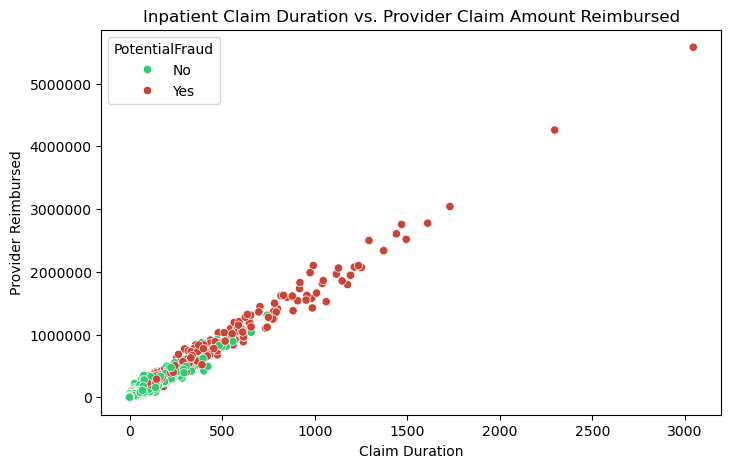

In [ ]:
# Plot a scatterplot, colored by PotentialFraud
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df1,
    x='IPClaimDurationSum',
    y='IPInscClaimAmtReimbursed',
    hue='PotentialFraud',
    palette=['#2ecc71','#cb4335'],  # Custom colors for the two categories
)
plt.title('Inpatient Claim Duration vs. Provider Claim Amount Reimbursed')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Claim Duration')
plt.ylabel('Provider Reimbursed')
plt.show()

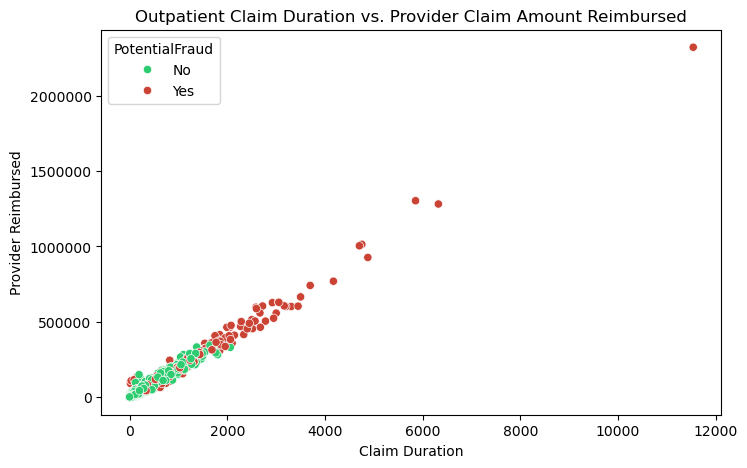

In [ ]:
# Plot a scatterplot, colored by PotentialFraud
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df1,
    x='OPClaimDurationSum',
    y='OPInscClaimAmtReimbursed',
    hue='PotentialFraud',
    palette=['#2ecc71','#cb4335'],  # Custom colors for the two categories
)
plt.title('Outpatient Claim Duration vs. Provider Claim Amount Reimbursed')
plt.xlabel('Claim Duration')
plt.ylabel('Provider Reimbursed')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [ ]:
df1

,Provider,IPClaimDurationSum,OPClaimDurationSum,PotentialFraud,IPInscClaimAmtReimbursed,OPInscClaimAmtReimbursed,total_fraud
0,PRV51001,25.0,11.0,No,97000.0,7640.0,104640.0
1,PRV51003,320.0,165.0,Yes,573000.0,32670.0,605670.0
2,PRV51004,0.0,213.0,No,0.0,52170.0,52170.0
3,PRV51005,0.0,1268.0,Yes,0.0,280910.0,280910.0
4,PRV51007,16.0,53.0,No,19000.0,14710.0,33710.0
...,...,...,...,...,...,...,...
5405,PRV57759,0.0,60.0,No,0.0,10640.0,10640.0
5406,PRV57760,0.0,7.0,No,0.0,4770.0,4770.0
5407,PRV57761,0.0,114.0,No,0.0,18470.0,18470.0
5408,PRV57762,0.0,0.0,No,0.0,1900.0,1900.0


In [ ]:
outpatient.loc[outpatient['Provider'] == 'PRV51001']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimDuration
2572,BENE11727,CLM733300,2009-12-17,2009-12-17,PRV51001,20,PHY383007,NaN,PHY383007,5953,42731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
48108,BENE24646,CLM372475,2009-05-22,2009-05-23,PRV51001,700,PHY405682,NaN,PHY402512,78650,51889,V5869,4019,V4581,49320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1
72343,BENE31617,CLM748221,2009-12-28,2009-12-28,PRV51001,900,PHY345302,NaN,NaN,V446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,59970,0
76150,BENE32715,CLM272936,2009-03-29,2009-03-30,PRV51001,500,PHY318842,PHY392882,NaN,78964,V442,5589,2720,33829,25002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,78902,1
133241,BENE49220,CLM452024,2009-07-04,2009-07-04,PRV51001,70,PHY402512,NaN,NaN,78965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,78900,0
157939,BENE56354,CLM403535,2009-06-08,2009-06-08,PRV51001,100,PHY350459,NaN,NaN,5168,36250,33819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,78659,0
160273,BENE57060,CLM578620,2009-09-14,2009-09-14,PRV51001,300,PHY311126,PHY394703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56722,0
177273,BENE61975,CLM260292,2009-03-22,2009-03-22,PRV51001,60,PHY392882,NaN,PHY392882,78901,7873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
238514,BENE79474,CLM180133,2009-02-06,2009-02-15,PRV51001,1000,PHY350459,NaN,NaN,71921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,9
245844,BENE81544,CLM352646,2009-05-11,2009-05-11,PRV51001,100,PHY392882,NaN,NaN,V1261,51902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,78605,0
